In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot
import math

In [2]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

In [3]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [4]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

In [5]:
source_df = df.copy()

In [6]:
source_df.index.names

FrozenList(['gicdesc', 'public_date'])

In [7]:
df = df.reset_index().loc[df.reset_index()['gicdesc'] == 'Energy'].set_index(source_df.index.names)

# Simulated Portafolio Approach

In [8]:
target_columns = ['simulated_portfolio_value']
returns_col = ['indret_ew']

# Define the initial portafolio value
initial_portafolio_value = 10000

# Convert MoM percentage change to multiplicative factors
df['multiplicative_factor'] = 1 + df[returns_col]
# Calculate the cumulative product of multiplicative factors
df['cumulative_factor'] = df['multiplicative_factor'].cumprod()

# Calculate the market capitalization using the cumulative factor
df[target_columns[0]] = initial_portafolio_value * df['cumulative_factor']
df[target_columns] = df[target_columns].shift(-1)
# df[target_columns] = df[target_columns].shift(1)

In [9]:
# Create holdout set
holdout_size = int(len(df) * 0.2)
holdout_df = df[-holdout_size:]
df = df[:-holdout_size]
test_size = int(len(df) * 0.2)
test_df = df[-test_size:]
df = df[:-test_size]

In [10]:
corr_all = df.corr()[target_columns]
corr_df = corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False).drop(['simulated_portfolio_value','cumulative_factor'])

In [11]:
top_10_corr_features = corr_df.head(10).index.tolist()

In [12]:
# from prophet import Prophet

# # Get the top 10 most correlated features
# top_10_corr_features = corr_all['simulated_portfolio_value'].abs().sort_values(ascending=False).drop(['simulated_portfolio_value']).head(10).index.tolist()

# # Prepare the dataframe for Prophet
# df_prophet = df[top_10_corr_features + target_columns]
# df_prophet = df_prophet.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})

# # Initialize the Prophet model
# model = Prophet()

# # Fit the model
# model.fit(df_prophet)

# # Make future predictions
# # future = model.make_future_dataframe(periods=3)
# future = test_df.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})
# forecast = model.predict(future)

In [13]:
# # Plot the forecast
# model.plot(forecast)
# # Plot the actual values
# plt.plot(forecast['ds'], test_df[target_columns[0]], 'r.', label='Actual')

# # Add legend and show the plot
# plt.legend()
# plt.show()

# # Plot the components
# model.plot_components(forecast)
# plt.show()

In [14]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import matplotlib.pyplot as plt

# # Prepare the data for ARIMA
# df_arima = df_prophet.set_index('ds')['y']
# # Split the data into training and test sets
# train_df = df_arima[:-12]  # use all but the last 12 months for training
# test_df = df_arima[-12:]  # use the last 12 months for testing

# # Fit the model on the training data
# model = pm.auto_arima(train_df, seasonal=True, m=12)
# model.fit(train_df)

# # Make predictions on the test data
# forecast = model.predict(n_periods=len(test_df))

# # Calculate RMSE
# rmse = sqrt(mean_squared_error(test_df, forecast))
# print(f'RMSE: {rmse}')

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(train_df.index, train_df, label='Train')
# plt.plot(test_df.index, test_df, label='Test')
# plt.plot(test_df.index, forecast, label='Predicted')
# plt.legend(loc='best')
# plt.title('Actual vs Predicted')
# plt.show()

RMSE: 0.1487256271011412


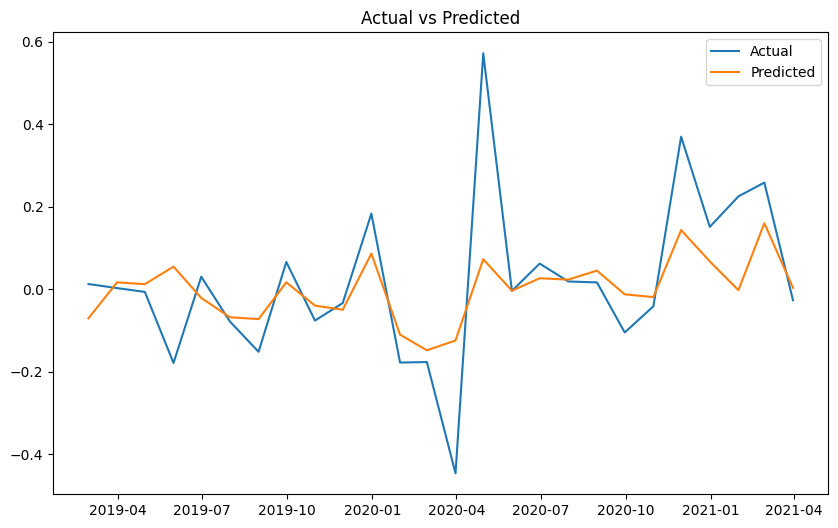

In [15]:
from cgi import test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare the data for Linear Regression
X_train = df[top_10_corr_features]
y_train = df[target_columns]
X_test = test_df[top_10_corr_features]
y_test = test_df[target_columns]

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Convert back to percentage change
actual_predictions = pd.Series(np.array(predictions).flatten()).pct_change()[1:]#.shift(-1)
actual_y_test = test_df[returns_col]
actual_y_test = np.array(actual_y_test.values).flatten()[1:]

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse = sqrt(mean_squared_error(actual_y_test, actual_predictions))
print(f'RMSE: {rmse}')



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
# plt.plot([x[1] for x in y_test.index], y_test, label='Actual')
# plt.plot([x[1] for x in y_test.index], predictions, label='Predicted')

plt.plot([x[1] for x in y_test.index][1:], actual_y_test, label='Actual')
plt.plot([x[1] for x in y_test.index][1:], actual_predictions, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted')
plt.show()

In [16]:
maxlag = 12

exclude_features = ['rd_sale_Median', 'adv_sale_Median', 'staff_sale_Median', target_columns[0]]
features_to_check = [x for x in corr_df.index.to_list() if x not in exclude_features]
# features_to_check = top_10_corr_features

In [17]:
# from statsmodels.tsa.stattools import grangercausalitytests

# granger_results = []
# for feature in features_to_check:
#     print(f'------- FEATURE: {feature} -------')
#     best_lag = float('inf')
#     best_p_value = float('inf')

#     # Run the Granger causality test
#     results = grangercausalitytests(df[[returns_col[0], feature]], maxlag)

#     # The results are stored in a dictionary. You can access the results for each lag as follows:
#     for i in range(maxlag, 0, -1):
#         p_value = results[i][0]['ssr_ftest'][1]  # get the p-value of the F-test
#         if p_value < best_p_value or (p_value == best_p_value and i < best_lag):
#             best_p_value = p_value
#             best_lag = i

#     # Add the results to the DataFrame
#     significant = best_p_value < 0.05  # change this to the significance level you want
#     granger_results.append({'Feature': feature, 'Best Lag': best_lag, 'P-Value': best_p_value, 'Significant': significant})
#     print(f'------- END OF FEATURE: {feature} -------')

# granger_df = pd.DataFrame(granger_results)
# # Display the results
# # granger_df.to_excel(f'{OUTPUT_PATH}/granger_causality.xlsx', index=False)

In [18]:
# lagged_df = df.copy()
# lagged_df['quick_ratio_Median_lag'] = lagged_df['quick_ratio_Median'].shift(1)
# sns.scatterplot(data=lagged_df, x='quick_ratio_Median_lag', y=returns_col[0])
# # sns.lineplot(data=df, x='public_date', y=returns_col[0])

In [48]:
# granger_df.loc[granger_df['Significant'] == True]
# granger_df.sort_values(by='P-Value').head(20)

In [54]:
import numpy as np
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# Prepare the dataframe
target_var = 'simulated_portfolio_value'
var_names = features_to_check + [target_var]
df_tigramite = pp.DataFrame(df[var_names].values, var_names=var_names)

# Initialize PCMCI object
pcmci = PCMCI(dataframe=df_tigramite, cond_ind_test=ParCorr(), verbosity=1)

# Compute the p-values
results = pcmci.run_pcmci(tau_max=maxlag, pc_alpha=0.05)



##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 12
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable pe_op_dil_Median has 4 link(s):
        (PEG_ltgforward_Median -1): max_pval = 0.00019, |min_val| =  0.398
        (simulated_portfolio_value -1): max_pval = 0.00770, |min_val| =  0.291
        (ocf_lct_Median -4): max_pval = 0.01062, |min_val| =  0.284
        (ocf_lct_Median -10): max_pval = 0.04684, |min_val| =  0.219

    Variable pe_op_basic_Median has 5 link(s):
        (PEG_ltgforward_Median -1): max_pval = 0.00027, |min_val| =  0.390
        (simulated_portfolio_value -1): max_pval = 0.01175, |min_val| =  0.275
        (CAPEI_Median -4): max_pval = 0.03892, |min_val| =  0.233
        (PEG_ltgforward_Median -4): max_pval = 0.04424, |min_val| =  0.221
        (ocf_lct_Median -10): max_pval = 0.04561, |min_val| =  0.220

    Variable CAP

In [63]:
# Get the results for the target variable
p_matrix = results['p_matrix']
# val_matrix = results['val_matrix']
# sig_matrix = np.multiply(p_matrix < 0.05, val_matrix)

# Get the results for the target variable
target_results = p_matrix[var_names.index(target_var), :]
target_results = pd.DataFrame(target_results, index=var_names)

In [90]:
reshaped_df = target_results[target_results.abs() < 0.05].reset_index().melt(id_vars='index' , var_name='lag', value_name='p-value').dropna().rename(columns={'index': 'column'})
sorted_list = reshaped_df.sort_values(by='p-value', key=abs)
sorted_list['value_str'] = sorted_list['p-value'].apply(lambda x: f'{x:.2f}') 
sorted_list.head(20)

,column,lag,p-value,value_str
132,multiplicative_factor,1,8.785726e-35,0.00
133,indret_ew,1,8.785726e-35,0.00
134,indret_vw,1,4.002131e-25,0.00
83,ptb_Median,1,2.146763e-23,0.00
80,ps_Median,1,1.178577e-21,0.00
145,simulated_portfolio_value,1,9.125691e-15,0.00
128,pcf_Median,1,6.302207e-14,0.00
156,ptb_Median,2,6.574487e-12,0.00
85,divyield_Median,1,5.030251e-11,0.00
153,ps_Median,2,9.357651e-11,0.00


Mean Absolute Error: 1036.3766227438555
Root Mean Squared Error: 1157.860735002003


<Axes: xlabel='Coefficient', ylabel='None'>

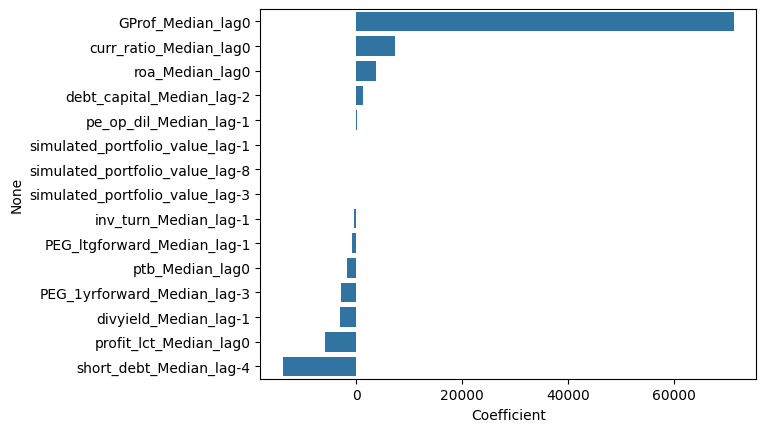

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming df is the cleaned and sorted DataFrame with necessary columns

# List of predictors with their respective lags
predictors = {
    'simulated_portfolio_value': [-1, -3, -8],
    'curr_ratio_Median': [0],
    'short_debt_Median': [-4],
    'inv_turn_Median': [-1],
    'GProf_Median': [0],
    'pe_op_dil_Median': [-1],
    'divyield_Median': [-1],
    'ptb_Median': [0],
    'profit_lct_Median': [0],
    'PEG_ltgforward_Median': [-1],
    'debt_capital_Median': [-2],
    'roa_Median': [0],
    'PEG_1yrforward_Median': [-3]
}

lagged_df = df.copy()
# Shift the dataframe columns by their respective lags
for predictor, lags in predictors.items():
    for lag in lags:
        lagged_df[f'{predictor}_lag{lag}'] = lagged_df[predictor].shift(-lag)

# Drop rows with any NaN values that were created by the shifting
lagged_df.dropna(inplace=True)

# Define the target variable and feature variables
target = 'simulated_portfolio_value'
features = [f'{pred}_lag{lag}' for pred, lags in predictors.items() for lag in lags]

X = lagged_df[features]
y = lagged_df[target]

# Split the data into training (80%) and testing (20%) sets
split_index = int(len(lagged_df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Optional: Print model coefficients
coef_df = pd.DataFrame(model.coef_, index=features, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
# print(coef_df)
sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df)



In [24]:
# Convert the predictions to a flat array
y_pred_flat = np.array(y_pred).flatten()

# Convert the predictions and the test data to percentage change
actual_predictions = pd.Series(y_pred_flat).pct_change()[1:]
actual_y_test = pd.Series(y_test).pct_change()[1:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_y_test, actual_predictions))
mae = mean_absolute_error(actual_y_test, actual_predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.0911020179398904
MAE: 0.07162469025330977


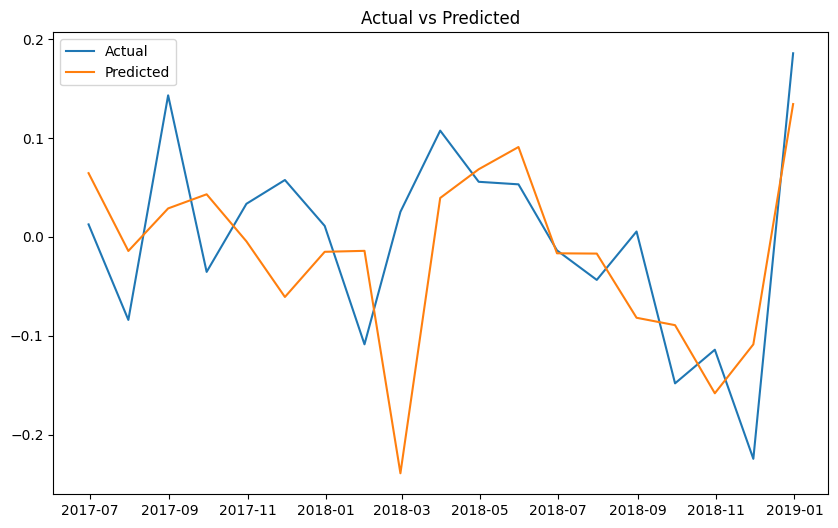

In [23]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
# plt.plot([x[1] for x in y_test.index], y_test, label='Actual')
# plt.plot([x[1] for x in y_test.index], predictions, label='Predicted')

plt.plot([x[1] for x in actual_y_test.index], actual_y_test.to_list(), label='Actual')
plt.plot([x[1] for x in actual_y_test.index], actual_predictions, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted')
plt.show()

Mean Absolute Error: 1263.7126521613848
Root Mean Squared Error: 1838.9405213099221


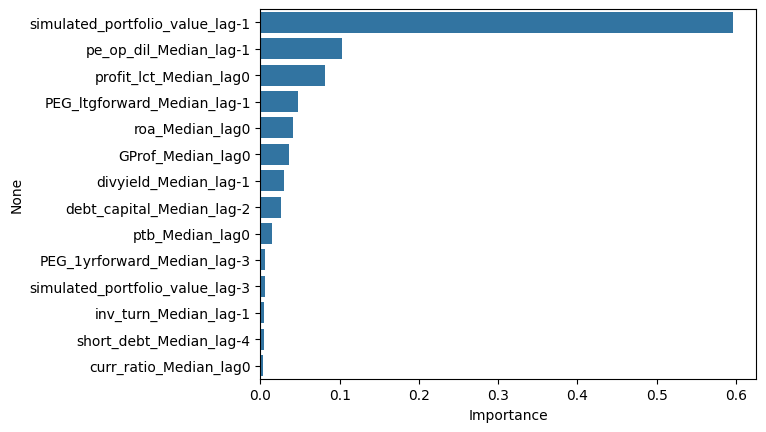

RMSE (percentage): 0.11663503231418908
MAE (percentage): 0.08813563020264369


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is the cleaned and sorted DataFrame with necessary columns

# List of predictors with their respective lags
predictors = {
    'simulated_portfolio_value': [-1, -3, -8],
    'curr_ratio_Median': [0],
    'short_debt_Median': [-4],
    'inv_turn_Median': [-1],
    'GProf_Median': [0],
    'pe_op_dil_Median': [-1],
    'divyield_Median': [-1],
    'ptb_Median': [0],
    'profit_lct_Median': [0],
    'PEG_ltgforward_Median': [-1],
    'debt_capital_Median': [-2],
    'roa_Median': [0],
    'PEG_1yrforward_Median': [-3]
}

lagged_df = df.copy()
# Shift the dataframe columns by their respective lags
for predictor, lags in predictors.items():
    for lag in lags:
        lagged_df[f'{predictor}_lag{lag}'] = lagged_df[predictor].shift(-lag)

# Drop rows with any NaN values that were created by the shifting
lagged_df.dropna(inplace=True)

# Define the target variable and feature variables
target = 'simulated_portfolio_value'
features = [f'{pred}_lag{lag}' for pred, lags in predictors.items() for lag in lags]

X = lagged_df[features]
y = lagged_df[target]

# Split the data into training (80%) and testing (20%) sets
split_index = int(len(lagged_df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Optional: Print feature importances
feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances)
plt.show()

# Convert the predictions to a flat array
y_pred_flat = np.array(y_pred).flatten()

# Convert the predictions and the test data to percentage change
actual_predictions = pd.Series(y_pred_flat).pct_change()[1:]
actual_y_test = pd.Series(y_test).pct_change()[1:]

# Calculate RMSE and MAE for percentage changes
rmse_pct = np.sqrt(mean_squared_error(actual_y_test, actual_predictions))
mae_pct = mean_absolute_error(actual_y_test, actual_predictions)
print(f'RMSE (percentage): {rmse_pct}')
print(f'MAE (percentage): {mae_pct}')


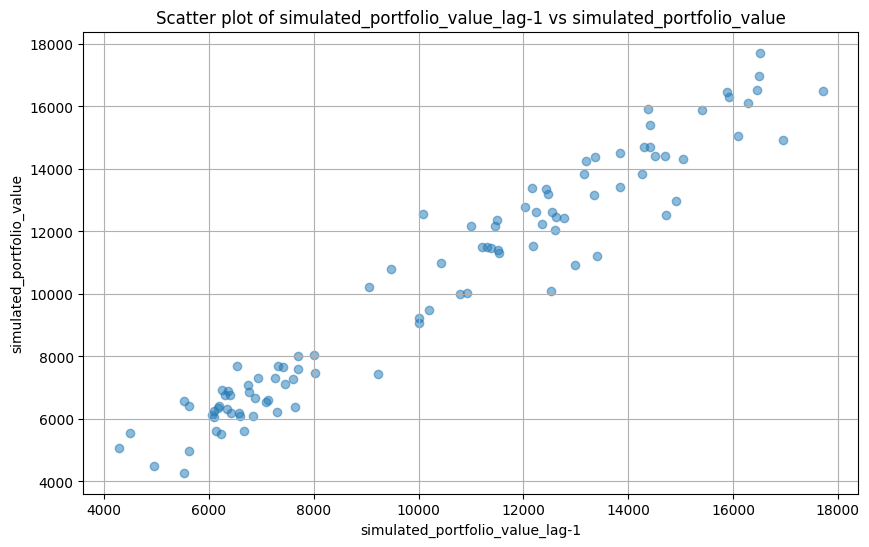

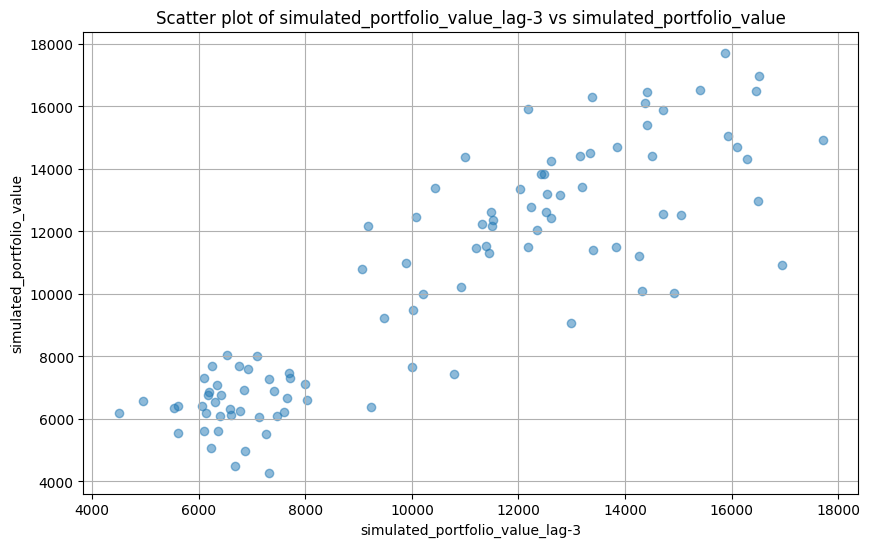

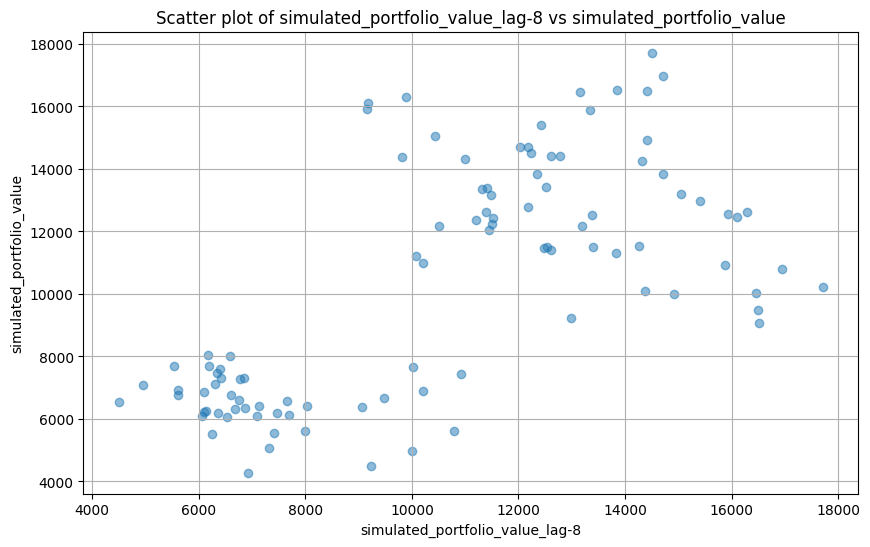

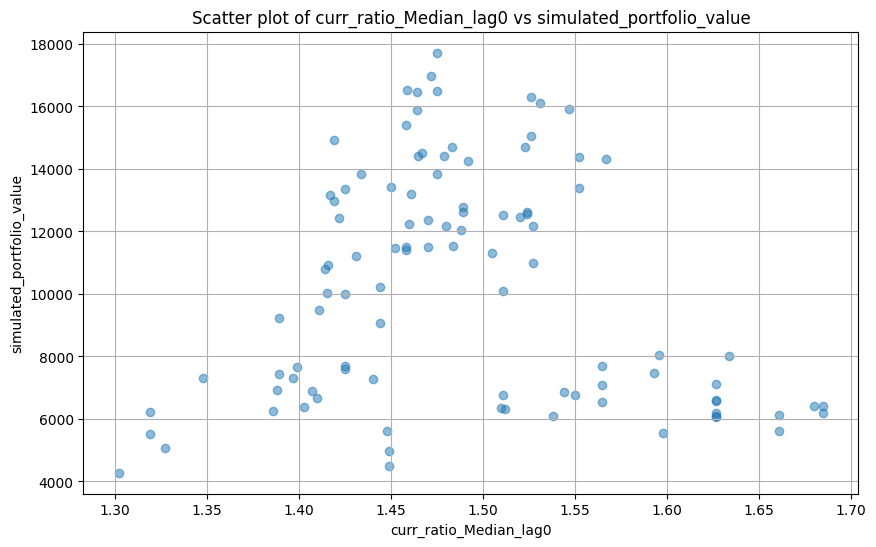

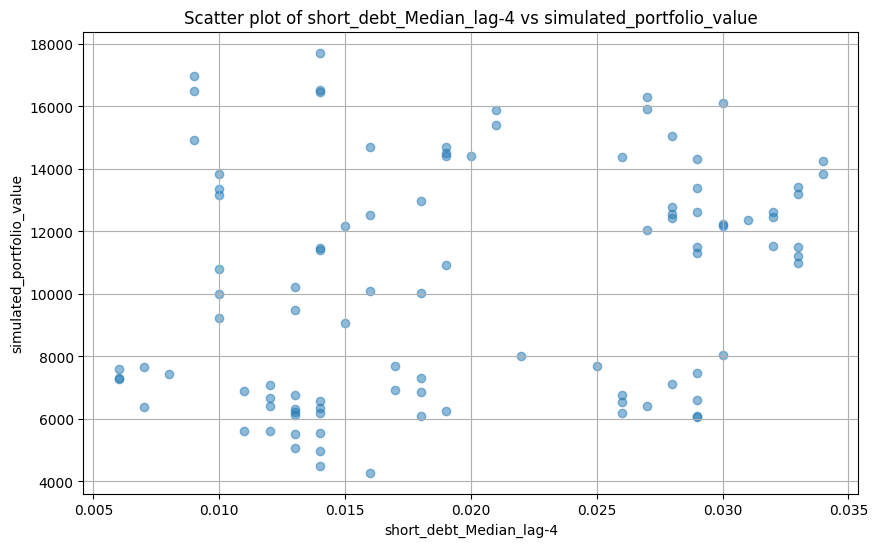

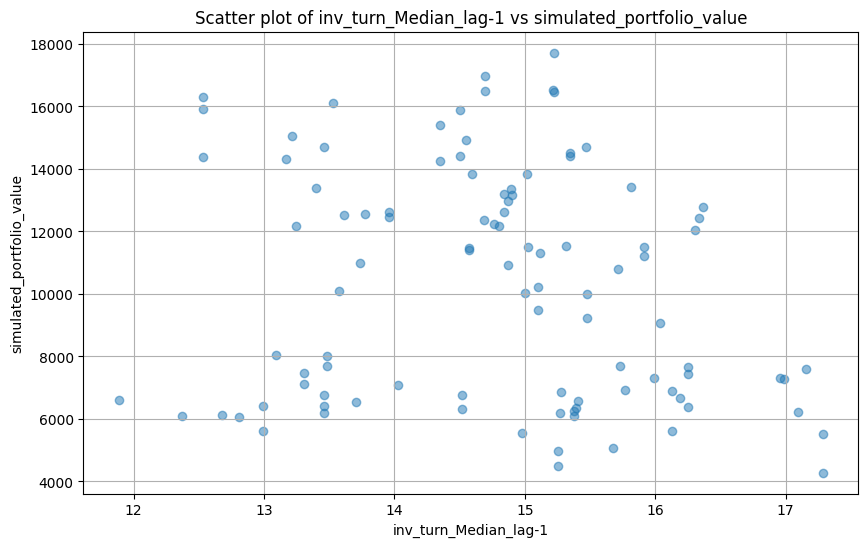

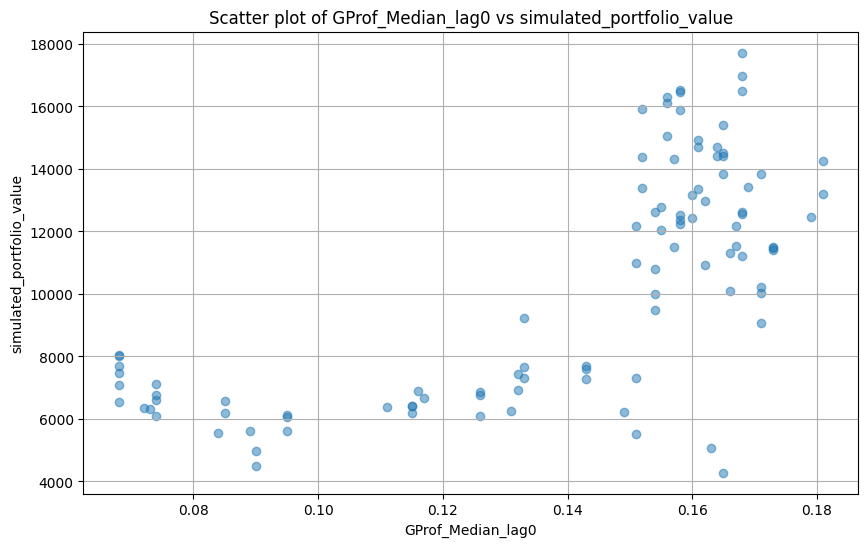

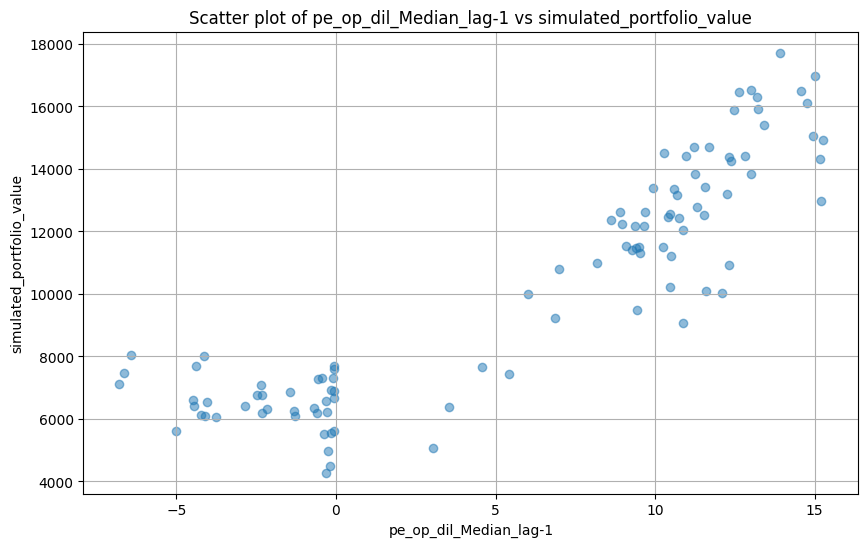

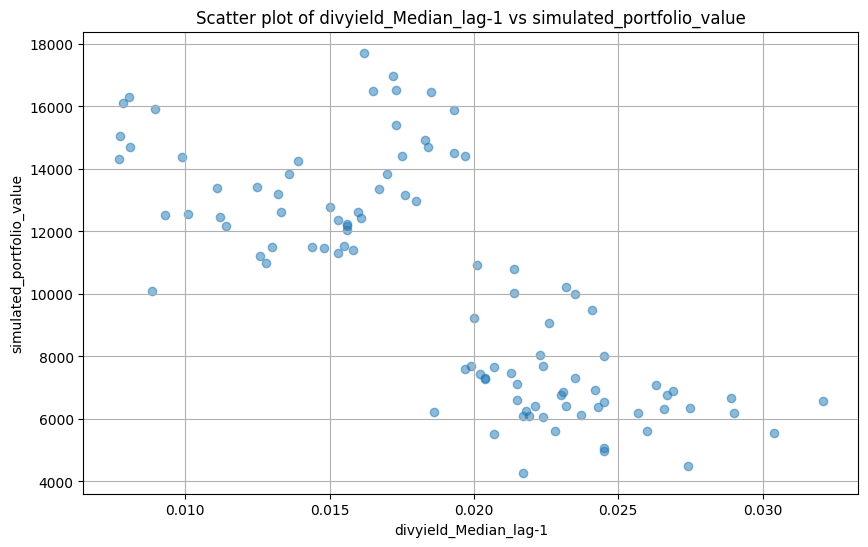

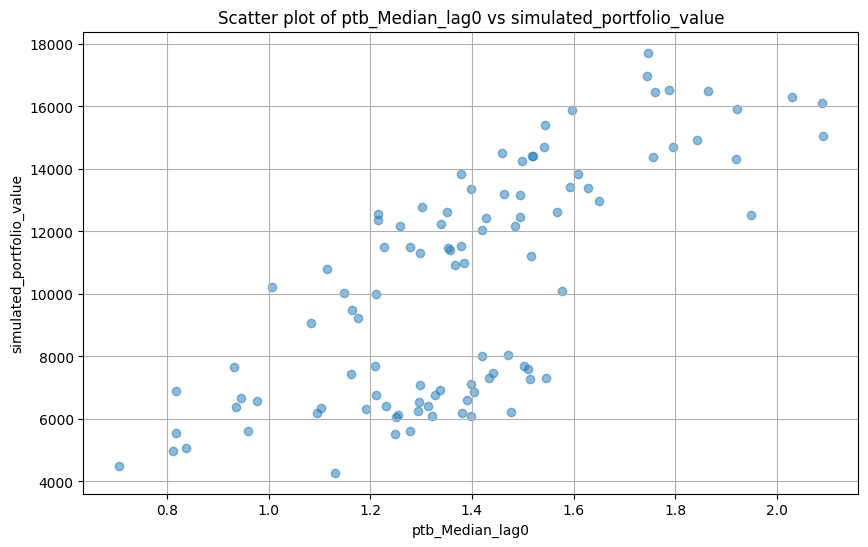

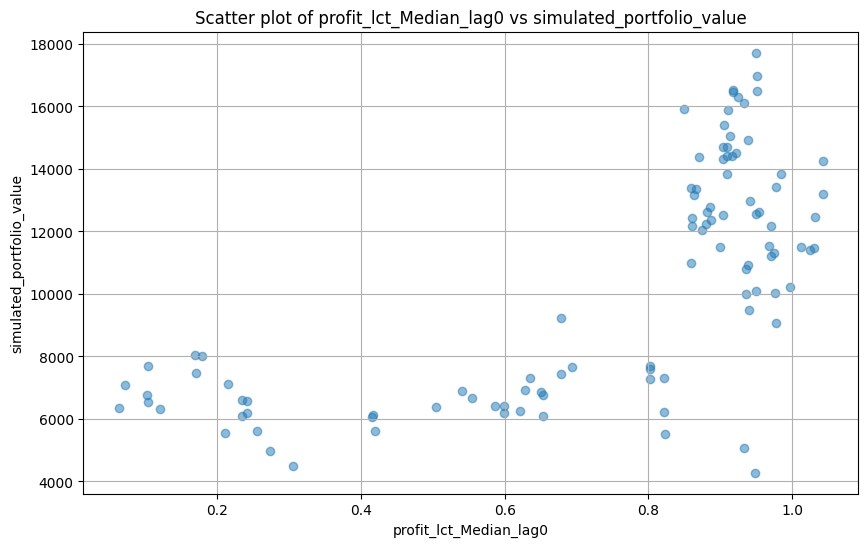

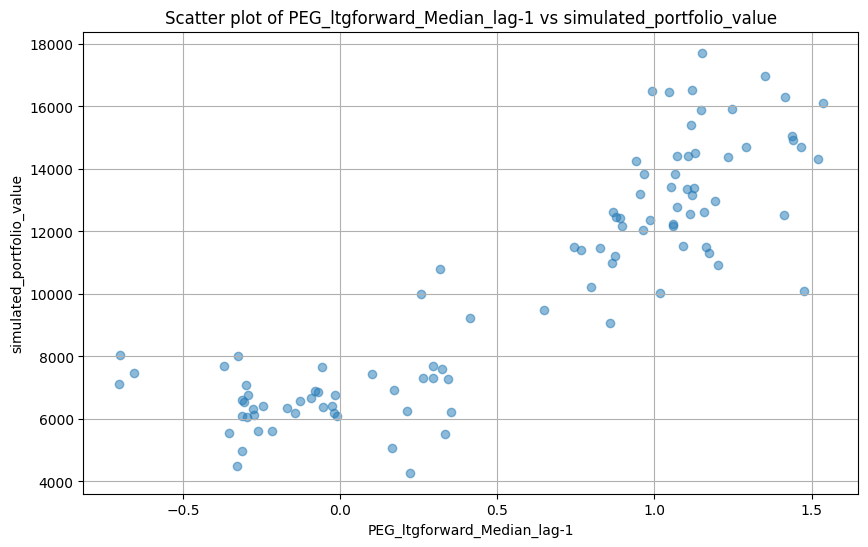

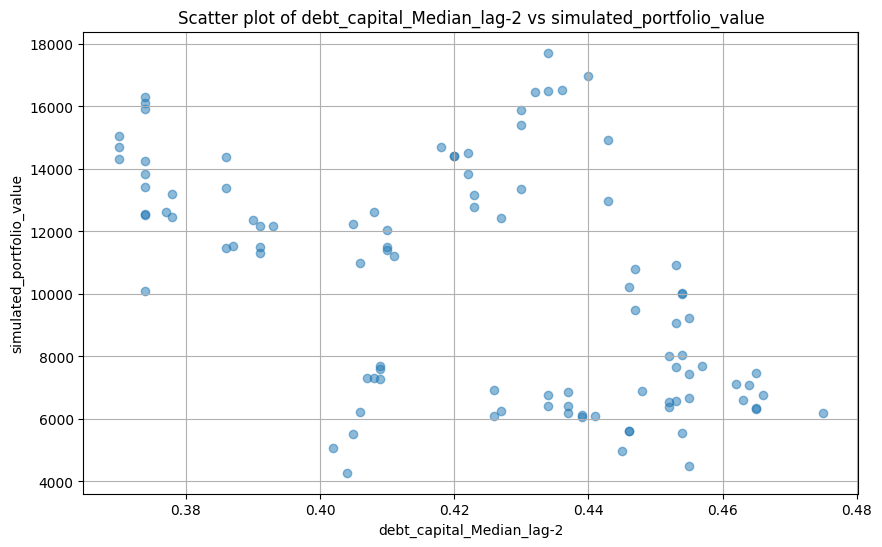

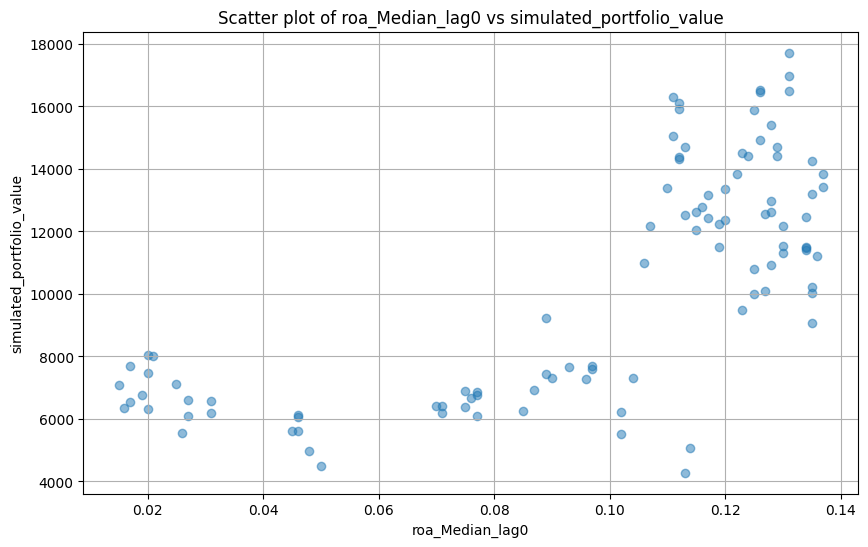

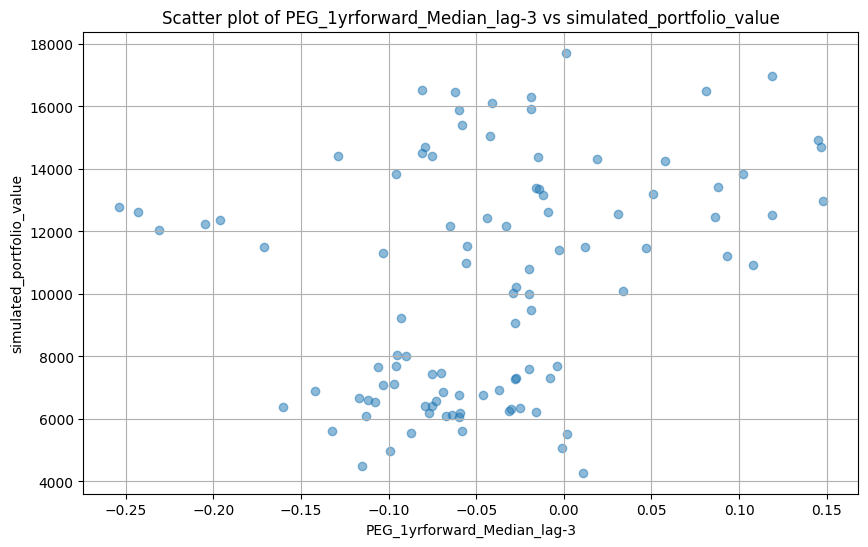

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the cleaned and sorted DataFrame with necessary columns

# List of predictors with their respective lags
predictors = {
    'simulated_portfolio_value': [-1, -3, -8],
    'curr_ratio_Median': [0],
    'short_debt_Median': [-4],
    'inv_turn_Median': [-1],
    'GProf_Median': [0],
    'pe_op_dil_Median': [-1],
    'divyield_Median': [-1],
    'ptb_Median': [0],
    'profit_lct_Median': [0],
    'PEG_ltgforward_Median': [-1],
    'debt_capital_Median': [-2],
    'roa_Median': [0],
    'PEG_1yrforward_Median': [-3]
}

lagged_df = df.copy()
# Shift the dataframe columns by their respective lags
for predictor, lags in predictors.items():
    for lag in lags:
        lagged_df[f'{predictor}_lag{lag}'] = lagged_df[predictor].shift(-lag)

# Drop rows with any NaN values that were created by the shifting
lagged_df.dropna(inplace=True)

# Define the target variable and feature variables
target = 'simulated_portfolio_value'
features = [f'{pred}_lag{lag}' for pred, lags in predictors.items() for lag in lags]

# Create scatter plots for each feature against the target
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.scatter(lagged_df[feature], lagged_df[target], alpha=0.5)
    plt.title(f'Scatter plot of {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()
